# SPRT vs Fixed-Horizon A/B Testing

This notebook compares:
- A fixed-horizon z-test
- A Sequential Probability Ratio Test (SPRT)

Both methods:
- Receive the **same number of samples per period**
- Use the **same data-generating process**
- Are evaluated across repeated simulations

Outputs include:
- Stopping time distribution
- Average stopping time
- Type I & Type II error rates
- Comparison plots


Summary post:

Since I heard that sequential testing lets us stop testing earlier, I have always wondered the intuitive reason. Yes, one of the main reasons is that sequential testing lets us peek at early signals that the control and treatment group may not be the same. And we can peek without the risk of p-hacking. But another reason is that the two - at least comparing the traditional sequential (Sequential Probability Ratio Test - SPRT) and fixed horizon testing - do not have the same alternative hypotheses. 

SPRT tests whether the difference between a specific value, while traditional AB tests test whether the difference is anything at all. This intuitively means that SPRT puts all its eggs in one basket. Assuming that the difference between treatment and control really is that value, sequential testing lets us stop testing earlier.


## 1. DGP Functions
Create functions for generating the data. This includes computing likelihoods, which we will use in SPRT. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


In [ ]:
def get_config():
    return {
        "alpha": 0.05,        # Type I error
        "beta": 0.20,         # Type II error
        "delta": 0.002,         # True effect size under H1
        "sigma": 1.0,         # Known variance
        "n_per_period": 100,  # Samples arriving per time period
        "max_periods": 200000,   # Max periods before forced stop
        "n_sims": 500,        # Number of simulation runs
        "seed": 123           # RNG seed
    }

In [ ]:

def generate_period_data(delta, sigma, n):
    return np.random.normal(loc=delta, scale=sigma, size=n)

def log_likelihood_ratio(samples, delta, sigma):
    mu0 = 0
    mu1 = delta
    return np.sum(
        -((samples - mu1)**2)/(2*sigma**2) + ((samples - mu0)**2)/(2*sigma**2)
    )

## 2. Testing functions. 

**SPRT Function**
Wald's Sequential Probability Ratio Test for normal means with known variance. Note that here we are testing two hypotheses: whether the mean is zero or equal to a given number. This is different from the fixed horizon test where the hypotheses are whether the mean is zero or not.

**Fixed horizon function**
This is just a power calculation to tell us the number of periods needed to acheive stat. sig. and the desired power.

In [16]:
def sprt_test(config, is_H1):
    ## Get data from config about statistical power, false positiverate
    ## expected impact, variance, and samples
    alpha = config["alpha"]
    beta = config["beta"]
    delta = config["delta"]
    sigma = config["sigma"]
    n_period = config["n_per_period"]
    max_periods = config["max_periods"]

    A = (1 - beta) / alpha
    B = beta / (1 - alpha)
    logA = np.log(A)
    logB = np.log(B)

    log_lr = 0.0

    for t in range(1, max_periods + 1):
        mean = delta if is_H1 else 0
        samples = generate_period_data(mean, sigma, n_period)
        log_lr += log_likelihood_ratio(samples, delta, sigma)

        if log_lr >= logA:
            return t, 1
        elif log_lr <= logB:
            return t, 0

    return max_periods, int(log_lr >= 0)

In [ ]:

def fixed_horizon_test_powered(config, is_H1):
    """
    Fixed-horizon z-test where the horizon is chosen to achieve
    power = 1 - beta at effect size delta.

    Hypotheses:
        H0: mu = 0
        H1: mu = delta
    """

    alpha = config["alpha"]
    beta = config["beta"]
    delta = config["delta"]
    sigma = config["sigma"]
    n_per_period = config["n_per_period"]

    # One-sided z-test (matches SPRT direction)
    z_alpha = norm.ppf(1 - alpha)
    z_beta = norm.ppf(1 - beta)

    # Required total sample size
    total_n = ((z_alpha + z_beta) * sigma / delta) ** 2
    total_n = int(np.ceil(total_n))

    # Convert to number of periods
    n_periods = int(np.ceil(total_n / n_per_period))

# Generate all data at once
    true_mean = delta if is_H1 else 0
    samples = np.random.normal(
        loc=true_mean,
        scale=sigma,
        size=n_periods * n_per_period
    )

    xbar = samples.mean()
    z_stat = (xbar - 0) / (sigma / np.sqrt(len(samples)))
    decision = int(z_stat >= z_alpha)
    
    return n_periods, decision



In [ ]:
##Run a test 
config = get_config()
np.random.seed(config["seed"])

sprt_stop, sprt_dec = sprt_test(config, is_H1=True)
fh_stop, fh_dec = fixed_horizon_test_powered(config, is_H1=True)
print('Using SPRT, test stopped after {0} periods with decision {1}'.format(sprt_stop, sprt_dec))
print('Using fixed-horizon test, test stops after {0} periods with decision {1}'.format(fh_stop, fh_dec))


Using SPRT, test stopped after 9224 periods with decision 1
Using fixed-horizon test, test stops after 15457 periods with decision 1


## 3. Simulation

I want to know whether SPRT can speed up experiment times. Our process is that for a given fixed horizon test that starts, calculate SPRT every day. How much faster does it achieve the correct result? Incorrect result?

In [26]:
def run_simulations():
    config = get_config()
    n_sims = config["n_sims"]
    np.random.seed(config["seed"])
    
    results = {
        "sprt_stop_H0": [], "sprt_dec_H0": [],
        "sprt_stop_H1": [], "sprt_dec_H1": [],
        "fh_stop_H0": [],   "fh_dec_H0": [],
        "fh_stop_H1": [],   "fh_dec_H1": []
    }

    for _ in range(n_sims):
        t0, d0 = sprt_test(config, is_H1=False)
        results["sprt_stop_H0"].append(t0)
        results["sprt_dec_H0"].append(d0)
        T0, D0 = fixed_horizon_test_powered(config, is_H1=False)
        results["fh_stop_H0"].append(T0)
        results["fh_dec_H0"].append(D0)

        t1, d1 = sprt_test(config, is_H1=True)
        results["sprt_stop_H1"].append(t1)
        results["sprt_dec_H1"].append(d1)
        T1, D1 = fixed_horizon_test_powered(config, is_H1=True)
        results["fh_stop_H1"].append(T1)
        results["fh_dec_H1"].append(D1)

    return results

In [27]:
results = run_simulations()
config = get_config()

avg_sprt_H0 = np.mean(results["sprt_stop_H0"])
avg_sprt_H1 = np.mean(results["sprt_stop_H1"])
avg_fh_H0 = np.mean(results["fh_stop_H0"])
avg_fh_H1 = np.mean(results["fh_stop_H1"])

type_I_sprt = np.mean(results["sprt_dec_H0"])
type_I_fh = np.mean(results["fh_dec_H0"])
type_II_sprt = 1 - np.mean(results["sprt_dec_H1"])
type_II_fh = 1 - np.mean(results["fh_dec_H1"])




(7346.758,
 10068.528,
 15457.0,
 15457.0,
 0.048,
 0.062,
 0.18600000000000005,
 0.18999999999999995)

In [30]:
print('Average duration when null is true: (SPRT): {0:3.2f} | (FH): {1:3.2f}'.format(avg_sprt_H0, avg_fh_H0))
print('Average duration when H1 is true: (SPRT): {0:3.2f} | (FH): {1:3.2f}'.format(avg_sprt_H1, avg_fh_H1))
print('Type I error rate (SPRT): {0:3.2f} | (FH): {1:3.2f}'.format(type_I_sprt, type_I_fh))
print('Type II error rate (SPRT): {0:3.2f} | (FH): {1:3.2f}'.format(type_II_sprt, type_II_fh))

Average duration when null is true: (SPRT): 7346.76 | (FH): 15457.00
Average duration when H1 is true: (SPRT): 10068.53 | (FH): 15457.00
Type I error rate (SPRT): 0.05 | (FH): 0.06
Type II error rate (SPRT): 0.19 | (FH): 0.19


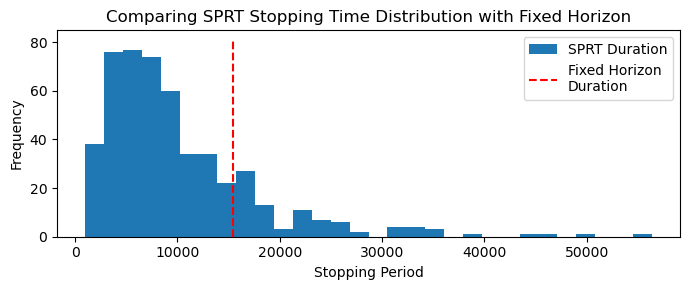

In [41]:
fig,ax = plt.subplots(ncols=1, nrows=1, figsize=(7,3))

ax.hist(results["sprt_stop_H1"], bins=30, label='SPRT Duration')
ax.vlines(avg_fh_H1, ymin=0, ymax=plt.ylim()[1], color='r', linestyle='dashed', label='Fixed Horizon\nDuration')
ax.set_title("Comparing SPRT Stopping Time Distribution with Fixed Horizon")
ax.set_xlabel("Stopping Period")
ax.set_ylabel("Frequency")
ax.legend()
plt.tight_layout()
plt.show()
